# Extract Method Data from the RADx-rad Project

Method Characteristics
* Analyte type: The specific target substance that a diagnostic method detects to indicate the presence of SARS-CoV-2 or COVID-19.
* Biorecognition type: The molecular mechanism or component used to specifically bind to the analyte.
* Signal detection: The physical or chemical technique used to quantify the recognition event between the analyte and biorecognition element.

Author: Peter W Rose, UC San Diego (pwrose.ucsd@gmail.com)

Data last updated: 2025-06-09

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set pandas to display all rows
pd.set_option('display.max_rows', None)
# Ensure plots display inline
%matplotlib inline

In [3]:
# Results directory
result_dir = "../../results"

In [4]:
df = pd.read_csv(os.path.join(result_dir, "data_elements.csv"), dtype=str)
df = df[["Id", "subproject", "phs_id", "project_num", "radx_id", "tier", "filename"]].copy()

In [5]:
def extract_data_element(df, data_elements):
    extract_list = []

    for _, row in df.iterrows():
        data_element_id = row["Id"]
        phs_id = row["phs_id"]
        sub_project = row["subproject"]
        data_file = row["filename"]

        if data_element_id in data_elements:
            data = pd.read_csv(data_file, dtype=str, keep_default_na=False)
            if "technology_platform" in data.columns:
                data = data[[data_element_id, "technology_platform"]].copy()
            else:
                data = data[[data_element_id]].copy()
                data["technology_platform"] = ""
            data.drop_duplicates(inplace=True)
            data.rename(columns={data_element_id: "value"}, inplace=True)
            data["characteristic"] = data_element_id
            data["phs_id"] = phs_id
            data["subproject"] = sub_project
            extract_list.append(data)

    extracted_data = pd.concat(extract_list, ignore_index=True)
    extracted_data.drop_duplicates(inplace=True)

    return extracted_data

#### Characteristics
* analyte_type
* biorecognition_type
* signal_detection

In [6]:
characteristics = extract_data_element(df, ["analyte_type", "target_analyte_type", 
                                            "biorecognition_type", "signal_detection"])
characteristics["value"] = characteristics['value'].str.split("|")
characteristics = characteristics.explode("value")
characteristics['value'] = characteristics['value'].replace('', 'unspecified')
characteristics = characteristics[characteristics['value'] != "control"]
characteristics['characteristic'] = characteristics['characteristic'].str.replace("target_analyte_type", "analyte_type")
# shorten the name
characteristics['value'] = characteristics['value'].str.replace("trimeric assembly of viral ", "")
characteristics.sort_values(by=["characteristic", "subproject", "value"], inplace=True)

In [7]:
characteristics.to_csv(os.path.join(result_dir, "characteristics.csv"), index=False)

In [8]:
characteristics

,value,technology_platform,characteristic,phs_id,subproject
101,antigen,Rolosense,analyte_type,phs002744.v1.p1,Automatic Detection & Tracing
118,antigen,,analyte_type,phs002744.v1.p1,Automatic Detection & Tracing
72,viral RNA,qRT-PCR,analyte_type,phs002546.v1.p1,Automatic Detection & Tracing
70,virus,ACE2 biosensor,analyte_type,phs002546.v1.p1,Automatic Detection & Tracing
71,virus,ssDNA aptasensor,analyte_type,phs002546.v1.p1,Automatic Detection & Tracing
78,virus,V-Pod DNA Net sensor for COVID-19 detection,analyte_type,phs002573.v1.p1,Automatic Detection & Tracing
93,virus,Screen printed carbon electrode,analyte_type,phs002700.v1.p1,Automatic Detection & Tracing
95,virus,Screen printed carbon electrode,analyte_type,phs002700.v1.p1,Automatic Detection & Tracing
96,antigen,,analyte_type,phs002709.v1.p1,Exosome
12,human RBD IgA,EFIRM_IgA,analyte_type,phs002544.v1.p1,Exosome


Text(0.5, 0, 'Count')

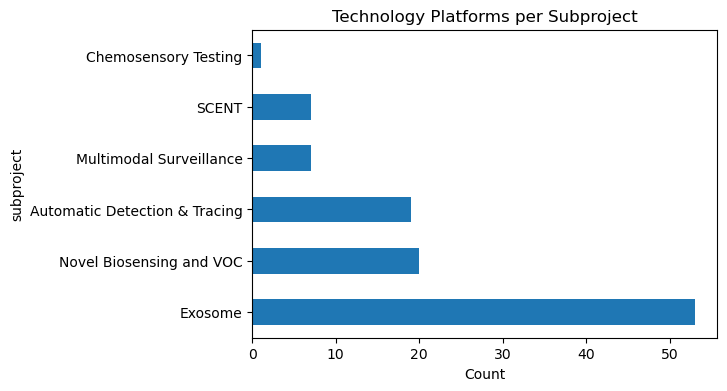

In [9]:
# Bar chart of subproject counts
characteristics['subproject'].value_counts().plot.barh(figsize=(6,4))
plt.title("Technology Platforms per Subproject")
plt.xlabel("Count")

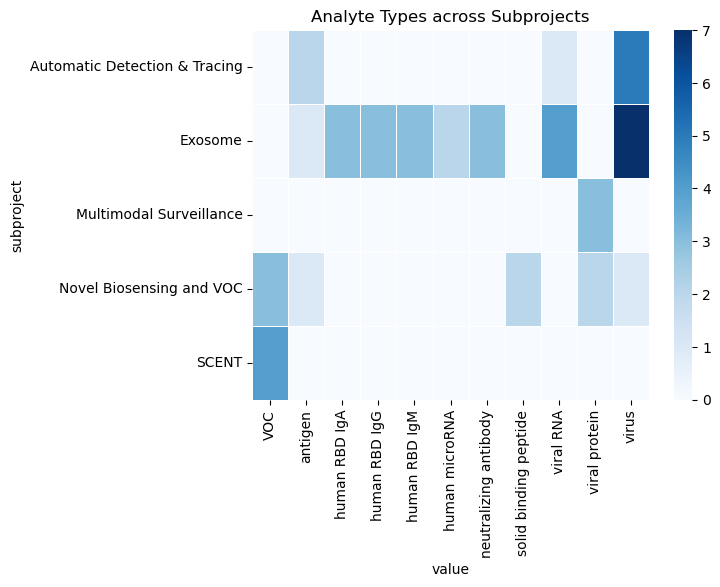

In [10]:
# Heatmap of analyte_type by subproject
pivot = (
    characteristics[characteristics['characteristic']=='analyte_type']
      .pivot_table(index='subproject', columns='value', aggfunc='size', fill_value=0)
)
sns.heatmap(pivot, cmap='Blues', linewidths=0.5)
plt.title("Analyte Types across Subprojects");

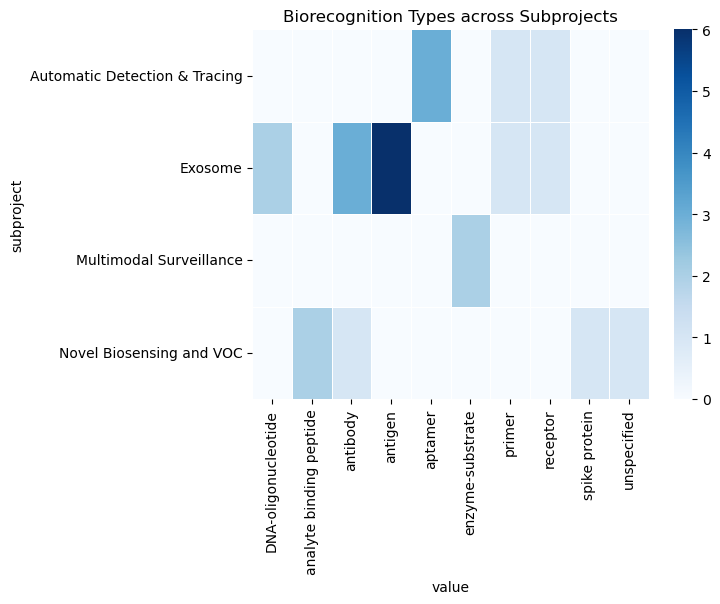

In [11]:
# Heatmap of biorecogniton_type by subproject
pivot = (
    characteristics[characteristics['characteristic']=='biorecognition_type']
      .pivot_table(index='subproject', columns='value', aggfunc='size', fill_value=0)
)
sns.heatmap(pivot, cmap='Blues', linewidths=0.5)
plt.title("Biorecognition Types across Subprojects");

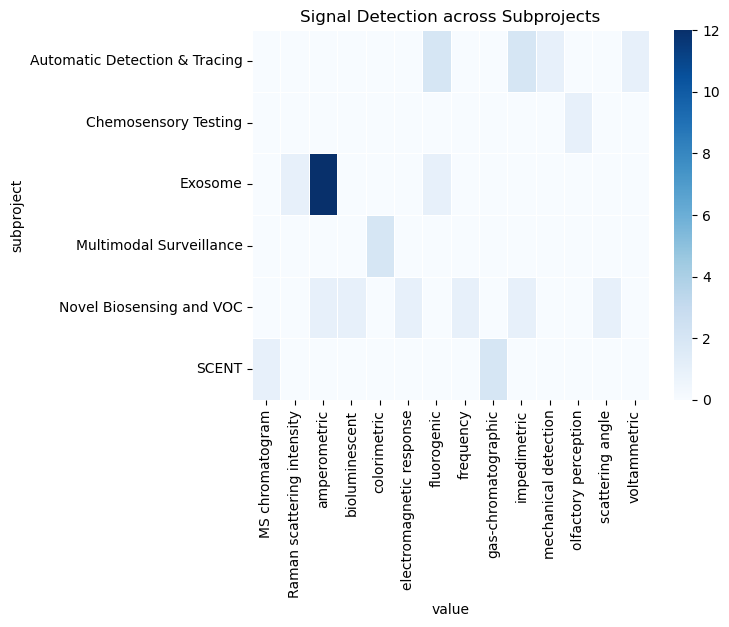

In [12]:
# Heatmap of signal_detection by subproject
pivot = (
    characteristics[characteristics['characteristic']=='signal_detection']
      .pivot_table(index='subproject', columns='value', aggfunc='size', fill_value=0)
)
sns.heatmap(pivot, cmap='Blues', linewidths=0.5)
plt.title("Signal Detection across Subprojects");

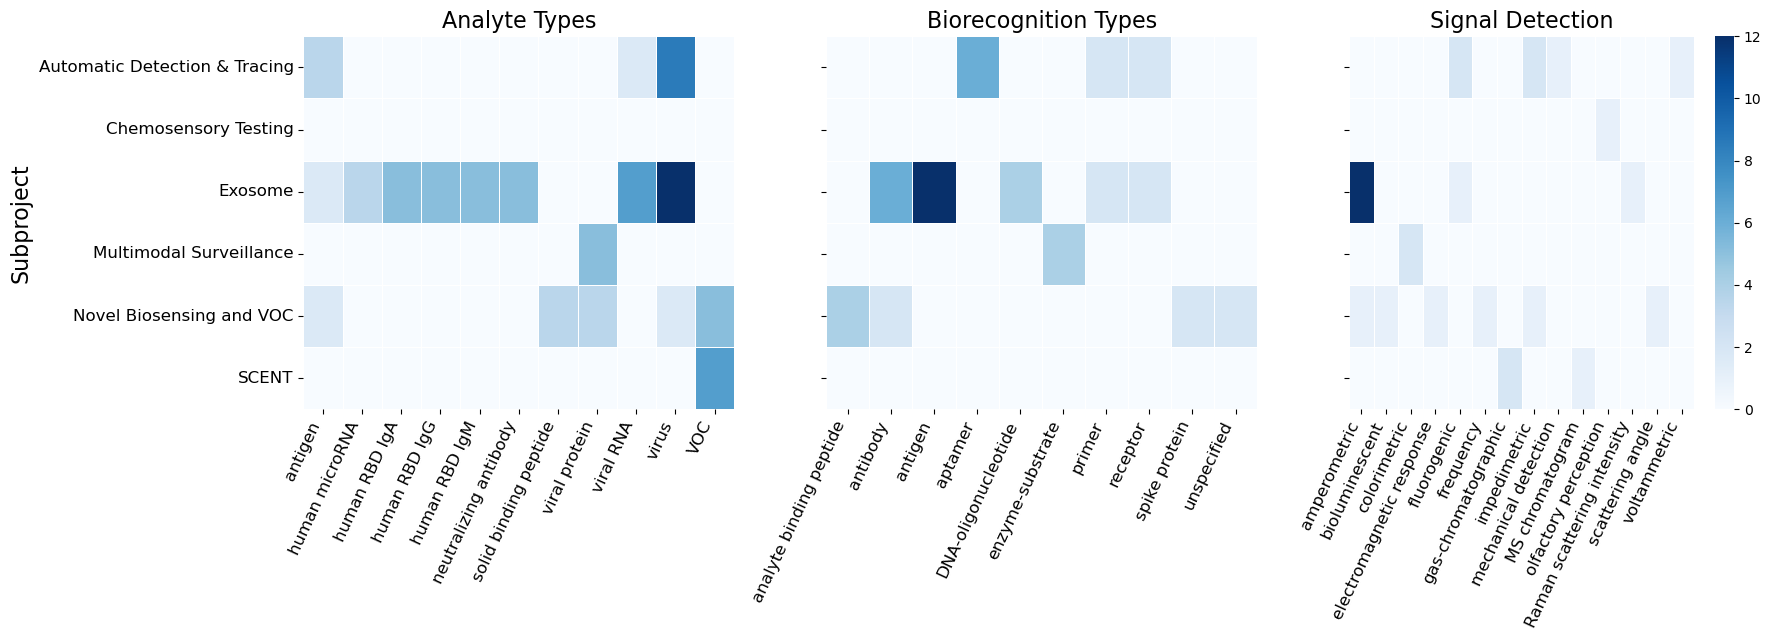

In [13]:
# Create a sorted, case‐insensitive list of all subprojects
all_subprojects = sorted(characteristics['subproject'].unique(), key=str.lower)

chars = [
    ('analyte_type',        'Analyte Types'),
    ('biorecognition_type', 'Biorecognition Types'),
    ('signal_detection',    'Signal Detection')
]

fig, axes = plt.subplots(
    ncols=len(chars),
    sharey=True,             # now safe because they all share the same index
    # figsize=(5 * len(chars), 5.5)
    figsize=(6 * len(chars), 6.5)
)

for ax, (char, title) in zip(axes, chars):
    pivot = (
        characteristics
          [characteristics['characteristic'] == char]
          .pivot_table(
              index='subproject',
              columns='value',
              aggfunc='size',
              fill_value=0
          )
    )

    pivot = pivot.reindex(
        index=all_subprojects,
        columns=sorted(pivot.columns, key=str.lower),
        fill_value=0
    )

    sns.heatmap(
        pivot,
        ax=ax,
        cmap='Blues',
        linewidths=0.5,
        cbar=(ax is axes[-1])
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=65, labelsize=12)
    for lbl in ax.get_xticklabels():
        lbl.set_ha('right')
 
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=12)

axes[0].set_ylabel('Subproject', fontsize=16)
plt.tight_layout()
plt.show()